In [9]:
from graph_utils import (
    get_repaired_interactions, USER_COLNAME, ITEM_COLNAME,
    GOWALLA_DATASET_NAME, YELP_2018_DATASET_NAME, AMAZON_BOOK_DATASET_NAME,
    df_table_to_latex, get_khop_neighbors_dict
)
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx

In [2]:
def get_user_item_degree_distribution(G: nx.Graph):
    users, items = nx.bipartite.sets(G)
    return np.array(list(dict(G.degree(users)).values())), np.array(list(dict(G.degree(items)).values()))

In [7]:
def get_k_nbrs_list(G, nodes, k):
    total_khop_nbrs_dict = defaultdict(list)

    for node in nodes:
        khop_nbrs_dict = get_khop_neighbors_dict(G, node, k)
        for i in range(1, k + 1):
            total_khop_nbrs_dict[i] += list(khop_nbrs_dict[i])

    total_khop_nbrs_counts_dict = {}
    for i in range(1, k + 1):
        total_khop_nbrs_counts_dict[i] = list(Counter(total_khop_nbrs_dict[i]).values())

    return total_khop_nbrs_counts_dict

def get_user_item_khop_neighbors_dicts(G: nx.Graph, k: int):
    users, items = nx.bipartite.sets(G)

    users_khop_nbrs = get_k_nbrs_list(G, users, k)
    items_khop_nbrs = get_k_nbrs_list(G, items, k)
    
    return users_khop_nbrs, items_khop_nbrs

In [30]:
def plot_degree_distributions(dataset_name, orig_distr, user_pruned_distr, item_pruned_distr, node_type, suffix=""):
    bins = np.linspace(0, 150, 50)

    plt.hist(orig_distr, histtype="bar", bins=bins, color="red", label=f"Original degree distribution of {node_type}s", alpha=0.5)
    plt.hist(user_pruned_distr, histtype="bar", bins=bins, color="green", label=f"User-{suffix} degree distribution of {node_type}s", alpha=0.5)
    plt.hist(item_pruned_distr, histtype="bar", bins=bins, color="blue", label=f"Item-{suffix} degree distribution of {node_type}s", alpha=0.5)
    plt.title(f"Degree distribution of {node_type}s on `{dataset_name}` dataset")

    plt.xlabel("Degree of a node")
    plt.ylabel("Count of nodes with such degree")
    plt.xlim(0, 150)
    plt.legend()
    plt.show()

# Hypothesis 1 (top degree pruner)

## Degree distribution check

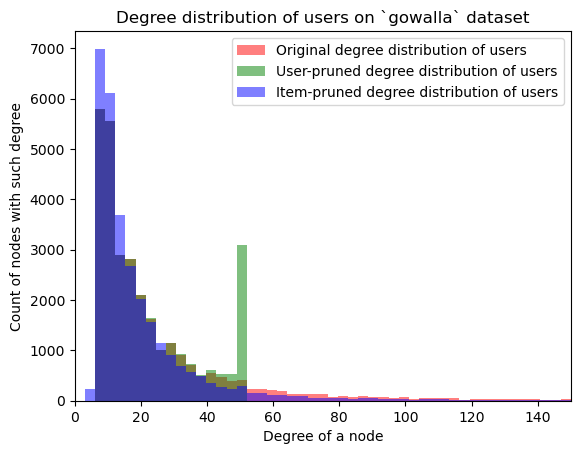

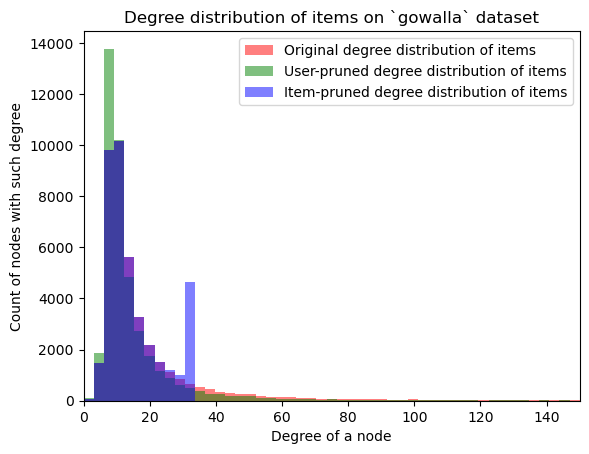

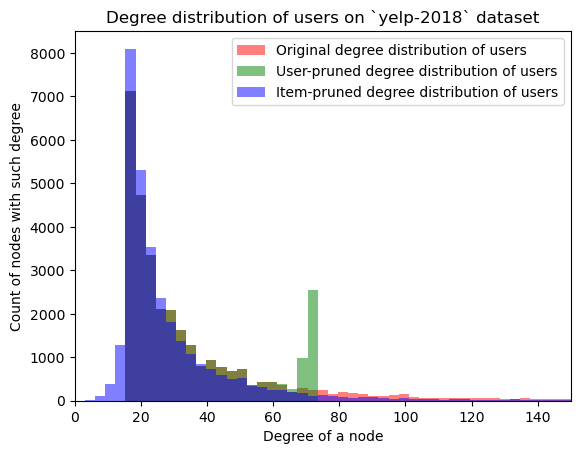

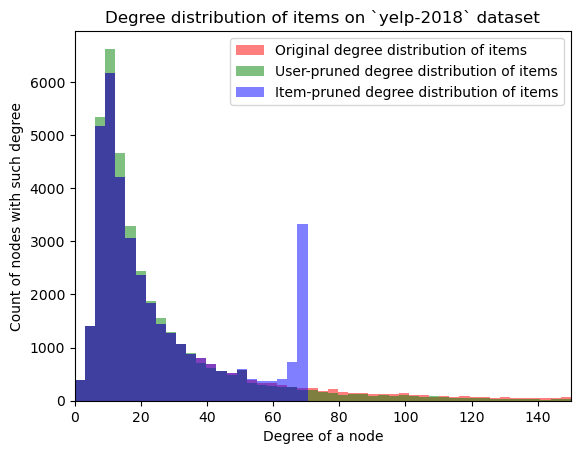

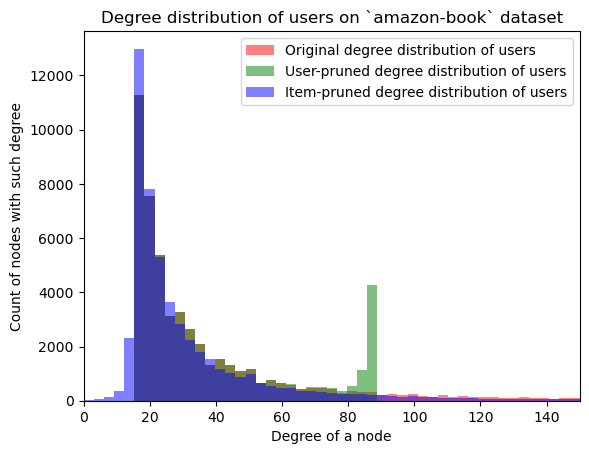

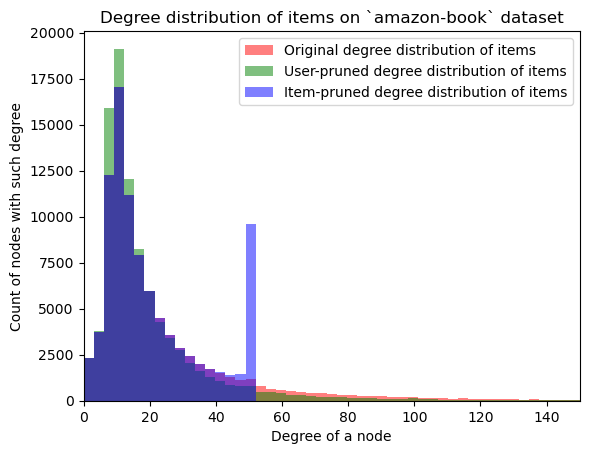

In [29]:
for dataset_name in [GOWALLA_DATASET_NAME, YELP_2018_DATASET_NAME, AMAZON_BOOK_DATASET_NAME]:
    G_orig, _, _ = get_repaired_interactions(dataset_name)
    G_user_pruned, _, _ = get_repaired_interactions(dataset_name + "--user--q=0.9")
    G_item_pruned, _, _ = get_repaired_interactions(dataset_name + "--item--q=0.9")

    orig_u_distr, orig_i_distr = get_user_item_degree_distribution(G_orig)
    user_pruned_u_distr, user_pruned_i_distr = get_user_item_degree_distribution(G_user_pruned)
    item_pruned_u_distr, item_pruned_i_distr = get_user_item_degree_distribution(G_item_pruned)

    plot_degree_distributions(dataset_name, orig_u_distr, user_pruned_u_distr, item_pruned_u_distr, USER_COLNAME, "pruned")
    plot_degree_distributions(dataset_name, orig_i_distr, user_pruned_i_distr, item_pruned_i_distr, ITEM_COLNAME, "pruned")

## Check appearance in k-order neighborhoods

In [38]:
def plot_khop_dict_distribution(
        orig_khop_counts_dict: dict,
        user_pruned_khop_counts_dict: dict,
        item_pruned_khop_counts_dict: dict,
        node_type: str,
        k: int,
    ):
    i_to_max = {2: 5_000}
    i_to_num = {2: 100}

    for i in range(2, k + 1):
        bins = np.linspace(0, i_to_max[i], i_to_num[i])

        plt.hist(orig_khop_counts_dict[i], histtype="bar", bins=bins, color="red", label=f"Original distribution of {node_type}s", alpha=0.5)
        plt.hist(user_pruned_khop_counts_dict[i], histtype="bar", bins=bins, color="green", label=f"User-pruned distribution of {node_type}s", alpha=0.5)
        plt.hist(item_pruned_khop_counts_dict[i], histtype="bar", bins=bins, color="blue", label=f"Item-pruned distribution of {node_type}s", alpha=0.5)
        plt.title(f"Distribution of times of appearances in others neighborhoods of order {i}\nof {node_type}s on `{dataset_name}` dataset")
    
        plt.xlabel(f"Number of times a node appeared\nin {i}-order neighborhoods of other nodes")
        plt.ylabel("Count")
        plt.legend()
        plt.show()

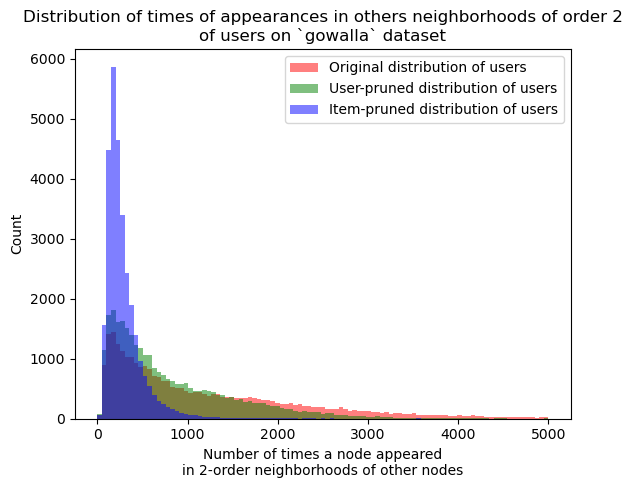

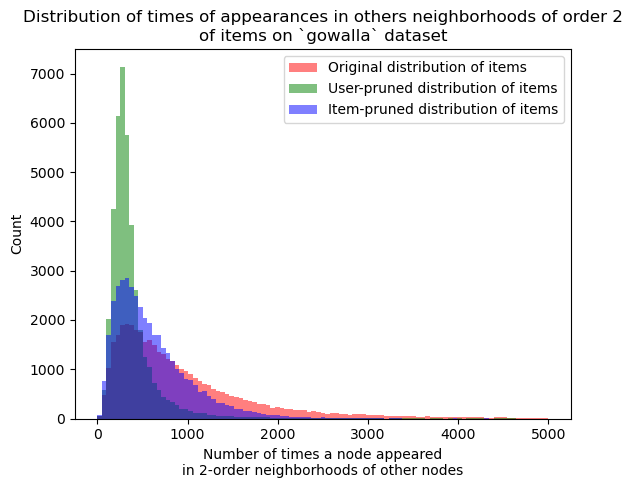

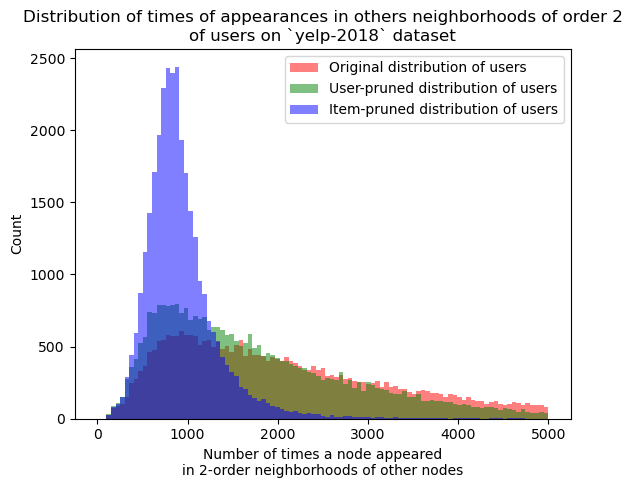

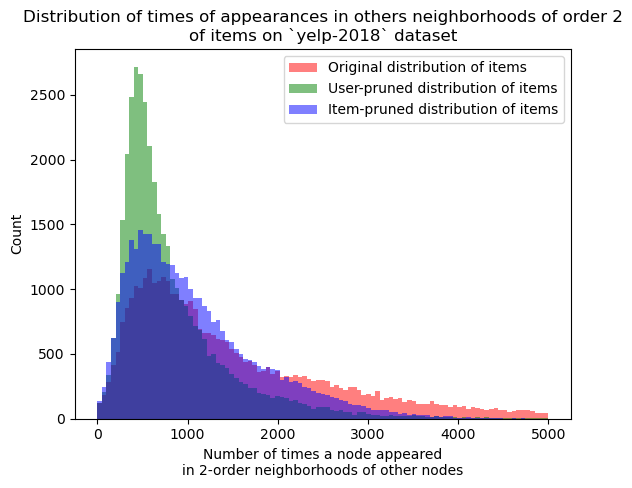

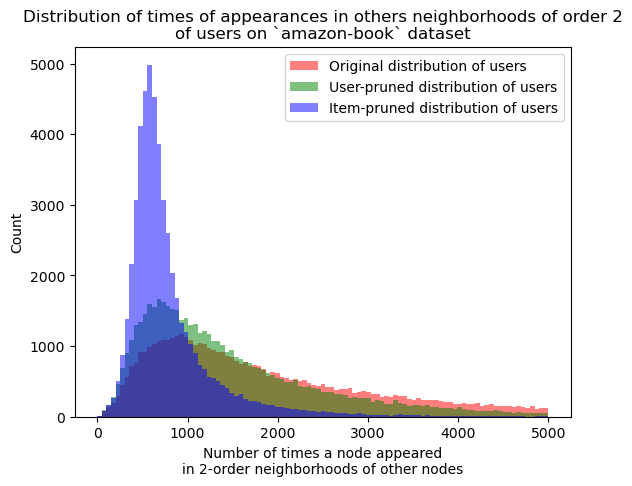

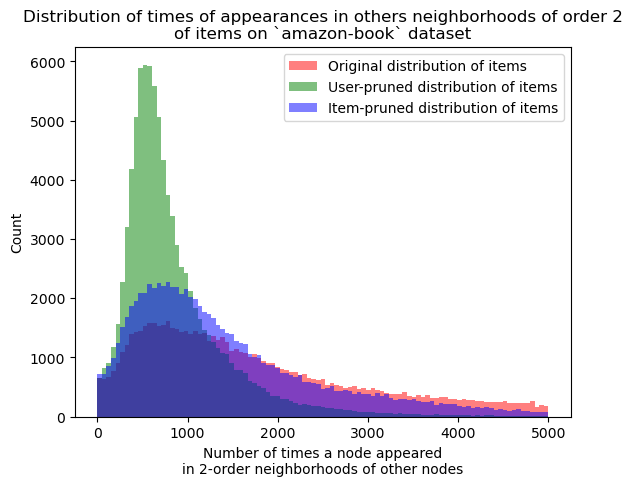

In [39]:
K = 2
for dataset_name in [GOWALLA_DATASET_NAME, YELP_2018_DATASET_NAME, AMAZON_BOOK_DATASET_NAME]:
    G_orig, _, _ = get_repaired_interactions(dataset_name)
    G_user_pruned, _, _ = get_repaired_interactions(dataset_name + "--user--q=0.9")
    G_item_pruned, _, _ = get_repaired_interactions(dataset_name + "--item--q=0.9")

    orig_u_khop_counts, orig_i_khop_counts = get_user_item_khop_neighbors_dicts(G_orig, k=K)
    user_pruned_u_khop_counts, user_pruned_i_khop_counts = get_user_item_khop_neighbors_dicts(G_user_pruned, k=K)
    item_pruned_u_khop_counts, item_pruned_i_khop_counts = get_user_item_khop_neighbors_dicts(G_item_pruned, k=K)

    plot_khop_dict_distribution(orig_u_khop_counts, user_pruned_u_khop_counts, item_pruned_u_khop_counts, "user", k=K)
    plot_khop_dict_distribution(orig_i_khop_counts, user_pruned_i_khop_counts, item_pruned_i_khop_counts, "item", k=K)

# Hypothesis 2 (Connecting to top betweenness nodes)

## Degree distribution

810127 825867 816900


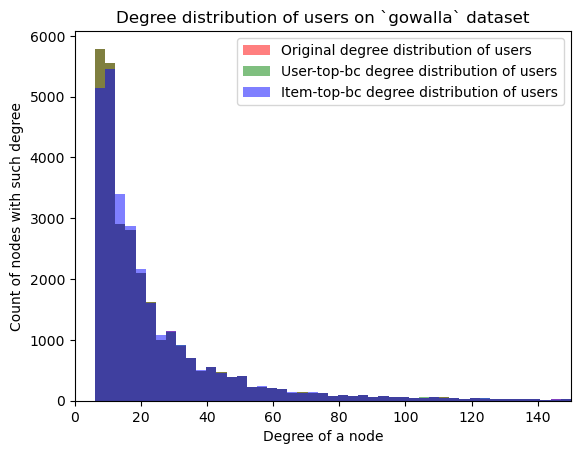

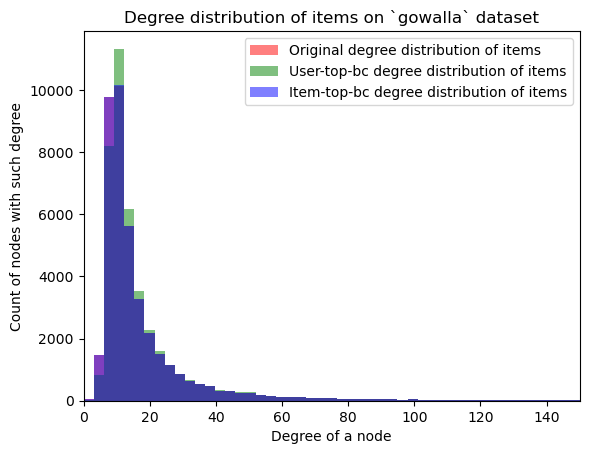

,Original,Top-BC User,Top-BC Item
max user degree,811,9239,811
max item degree,1415,1415,3594


\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
 & Original & Top-BC User & Top-BC Item \\
\midrule
max user degree & 811 & 9239 & 811 \\
max item degree & 1415 & 1415 & 3594 \\
\bottomrule
\end{tabular}
\caption{Max degrees among datasets}
\end{table}
1237258 1248075 1242750


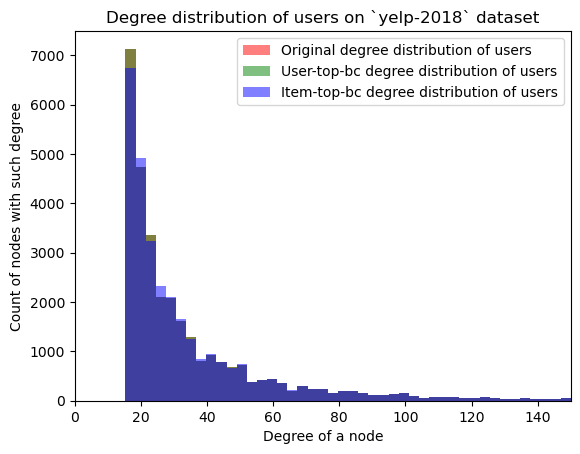

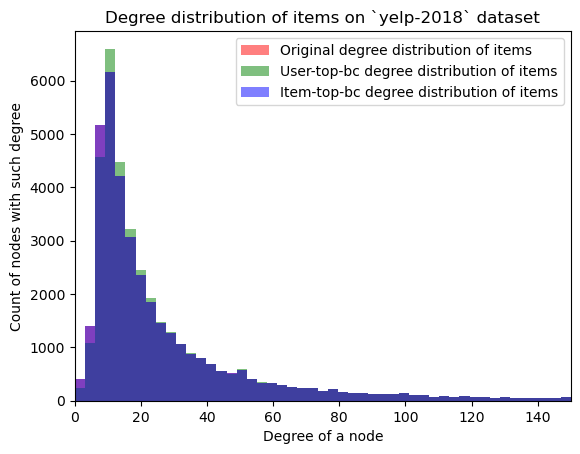

,Original,Top-BC User,Top-BC Item
max user degree,1848,8084,1848
max item degree,1258,1258,4900


\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
 & Original & Top-BC User & Top-BC Item \\
\midrule
max user degree & 1848 & 8084 & 1848 \\
max item degree & 1258 & 1258 & 4900 \\
\bottomrule
\end{tabular}
\caption{Max degrees among datasets}
\end{table}
2380729 2403121 2389641


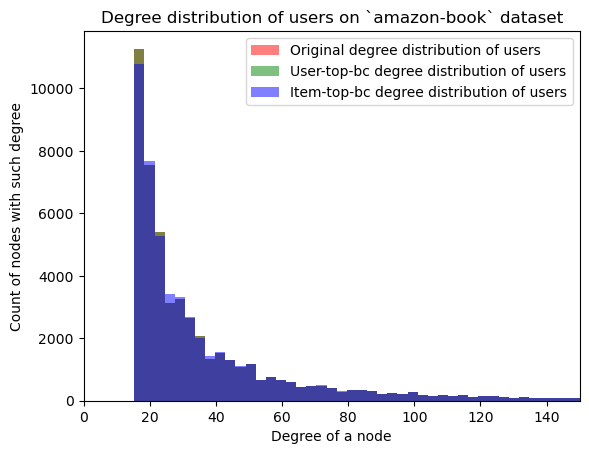

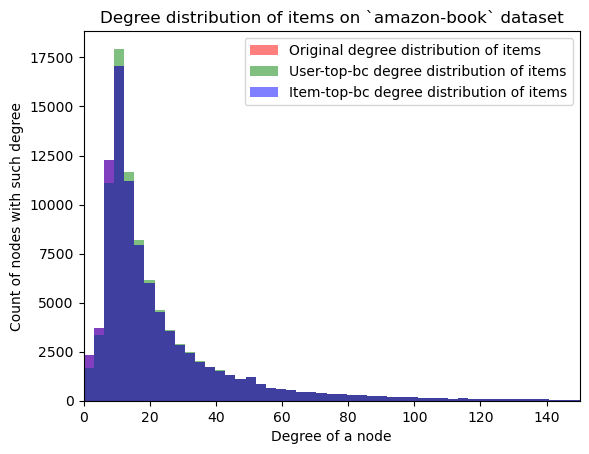

,Original,Top-BC User,Top-BC Item
max user degree,10682,15128,10682
max item degree,1741,1741,6128


\begin{table}[H]
\centering
\begin{tabular}{lrrr}
\toprule
 & Original & Top-BC User & Top-BC Item \\
\midrule
max user degree & 10682 & 15128 & 10682 \\
max item degree & 1741 & 1741 & 6128 \\
\bottomrule
\end{tabular}
\caption{Max degrees among datasets}
\end{table}


In [36]:
for dataset_name in [GOWALLA_DATASET_NAME, YELP_2018_DATASET_NAME, AMAZON_BOOK_DATASET_NAME]:
    G_orig, _, _ = get_repaired_interactions(dataset_name)
    G_user_top_bc, _, _ = get_repaired_interactions(dataset_name + "--c-bc--user--q=0.99")
    G_item_top_bc, _, _ = get_repaired_interactions(dataset_name + "--c-bc--item--q=0.99")

    print(len(G_orig.edges), len(G_user_top_bc.edges), len(G_item_top_bc.edges))

    orig_u_distr, orig_i_distr = get_user_item_degree_distribution(G_orig)
    user_top_bc_u_distr, user_top_bc_i_distr = get_user_item_degree_distribution(G_user_top_bc)
    item_top_bc_u_distr, item_top_bc_i_distr = get_user_item_degree_distribution(G_item_top_bc)

    plot_degree_distributions(dataset_name, orig_u_distr, user_top_bc_u_distr, item_top_bc_u_distr, USER_COLNAME, "top-bc")
    plot_degree_distributions(dataset_name, orig_i_distr, user_top_bc_i_distr, item_top_bc_i_distr, ITEM_COLNAME, "top-bc")

    df_max = pd.DataFrame.from_dict(
        {
            "max user degree": [orig_u_distr.max(), user_top_bc_u_distr.max(), item_top_bc_u_distr.max()],
            "max item degree": [orig_i_distr.max(), user_top_bc_i_distr.max(), item_top_bc_i_distr.max()]
        },
        orient="index",
        columns=["Original", "Top-BC User", "Top-BC Item"],
    )

    display(df_max)
    print(df_table_to_latex(df_max, caption="Max degrees among datasets"))
    

## Analysis of how many nodes are top by degree and by betwenness centrality at the same time

In [25]:
from collections import OrderedDict

In [26]:
def get_top_degree_bc_intersection_sizes(G: nx.Graph, bc_dict: dict, nodes: list, qs: list):
    degrees = np.array(list(dict(G.degree(nodes)).values()))
    bcs = np.array([bc_dict[node] for node in nodes])
    bcs_q = np.quantile(bcs, qs)

    avg_degree_for_bc_dict = OrderedDict()
    for i, q in enumerate(qs):
        avg_degree_for_bc_dict[q] = np.average(degrees[bcs > bcs_q[i]])

    return avg_degree_for_bc_dict

In [27]:
def plot_avg_degree(avg_users_degree_for_bc_dict: dict, avg_items_degree_for_bc_dict: dict, dataset_name: str):
    plt.plot(*tuple(zip(*(avg_users_degree_for_bc_dict.items()))), label="Average users degree", color="red")
    plt.plot(*tuple(zip(*(avg_items_degree_for_bc_dict.items()))), label="Average items degree", color="blue")
    plt.title(f"Average degree for top betweenness nodes\n on {dataset_name}")
    plt.xlabel("betwenness centrality quantile")
    plt.ylabel("Average degree")
    plt.legend()
    plt.show()

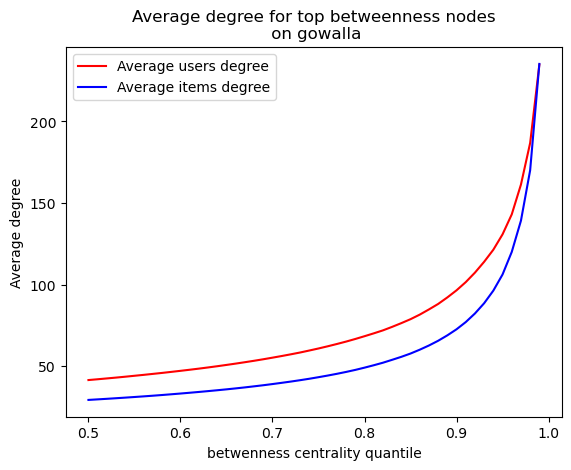

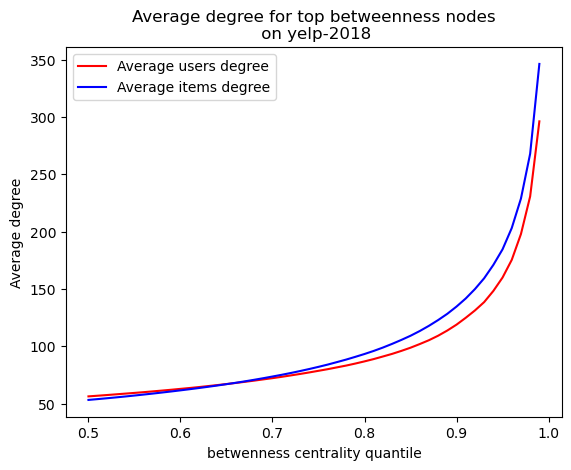

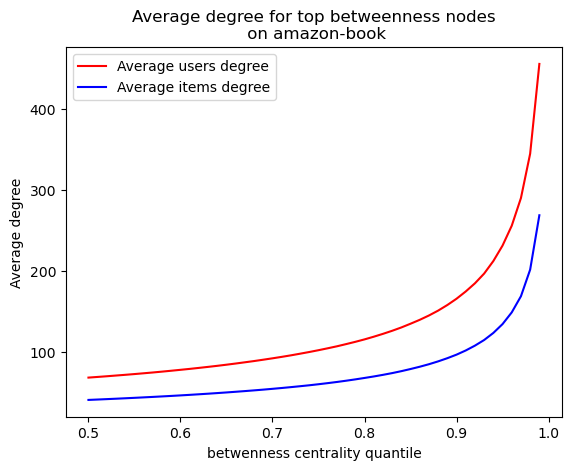

In [28]:
for dataset_name in [GOWALLA_DATASET_NAME, YELP_2018_DATASET_NAME, AMAZON_BOOK_DATASET_NAME]:
    G_orig, _, _ = get_repaired_interactions(dataset_name)

    bc_dict = pd.read_csv(f"betweenness/{dataset_name}.csv", index_col="node").to_dict("index")
    bc_dict = {node: column_dict["bc"] for node, column_dict in bc_dict.items()}

    users, items = nx.bipartite.sets(G_orig)
    qs = np.arange(0.5, 1, 0.01)

    avg_users_degree_for_bc_dict = get_top_degree_bc_intersection_sizes(G_orig, bc_dict, users, qs)
    avg_items_degree_for_bc_dict = get_top_degree_bc_intersection_sizes(G_orig, bc_dict, items, qs)

    plot_avg_degree(avg_users_degree_for_bc_dict, avg_items_degree_for_bc_dict, dataset_name)

# Second-order neighbors

In [17]:
def plot_khop_dict_distribution_h2(
        orig_khop_counts_dict: dict,
        user_pruned_khop_counts_dict: dict,
        item_pruned_khop_counts_dict: dict,
        node_type: str,
        k: int,
    ):
    i_to_max = {2: 10_000}
    i_to_num = {2: 200}

    for i in range(2, k + 1):
        bins = np.linspace(0, i_to_max[i], i_to_num[i])

        plt.hist(orig_khop_counts_dict[i], histtype="bar", bins=bins, color="red", label=f"Original distribution of {node_type}s", alpha=0.5)
        plt.hist(user_pruned_khop_counts_dict[i], histtype="bar", bins=bins, color="green", label=f"User-top-bc distribution of {node_type}s", alpha=0.5)
        plt.hist(item_pruned_khop_counts_dict[i], histtype="bar", bins=bins, color="blue", label=f"Item-top-bc distribution of {node_type}s", alpha=0.5)
        plt.title(f"Distribution of times of appearances in others neighborhoods of order {i}\nof {node_type}s on `{dataset_name}` dataset")
    
        plt.xlabel(f"Number of times a node appeared\nin {i}-order neighborhoods of other nodes")
        plt.ylabel("Count")
        plt.legend()
        plt.show()

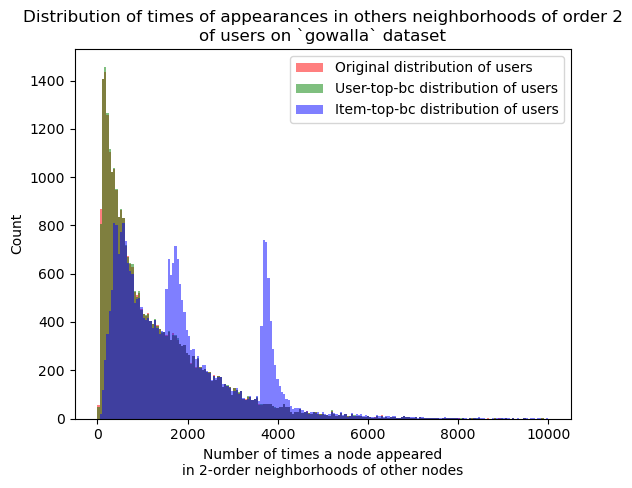

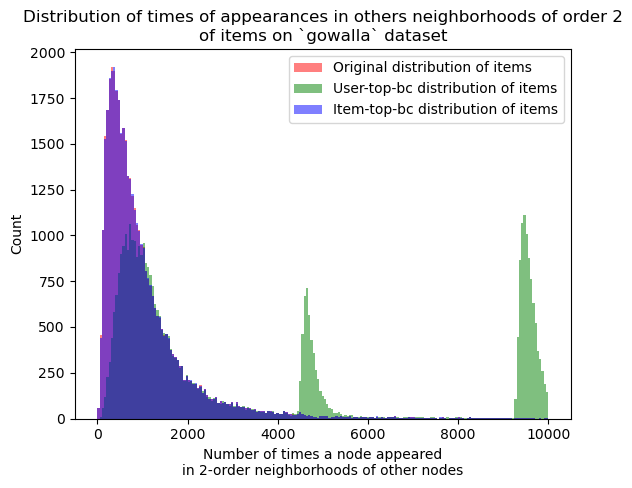

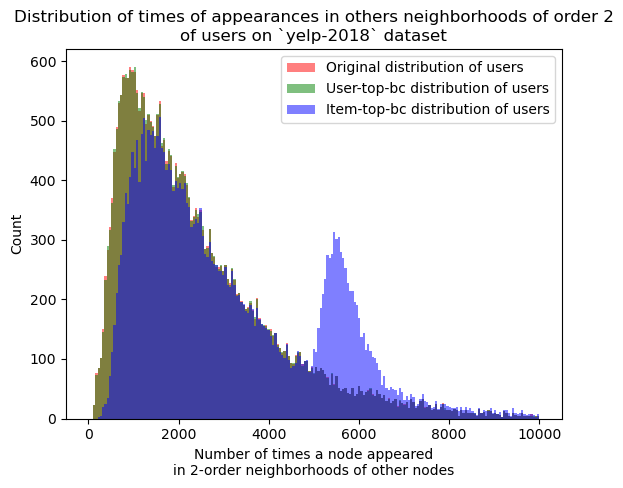

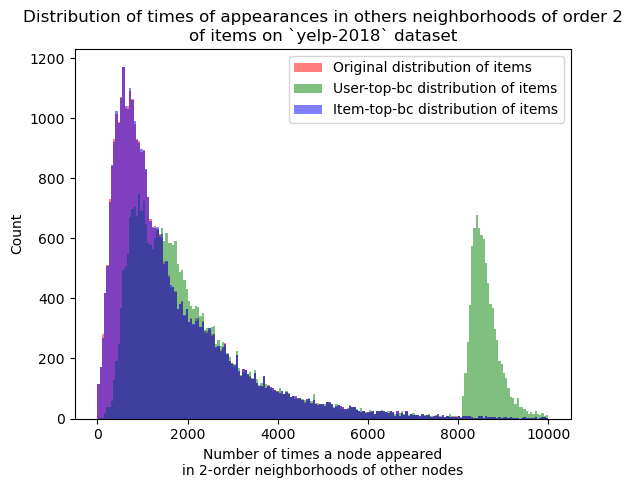

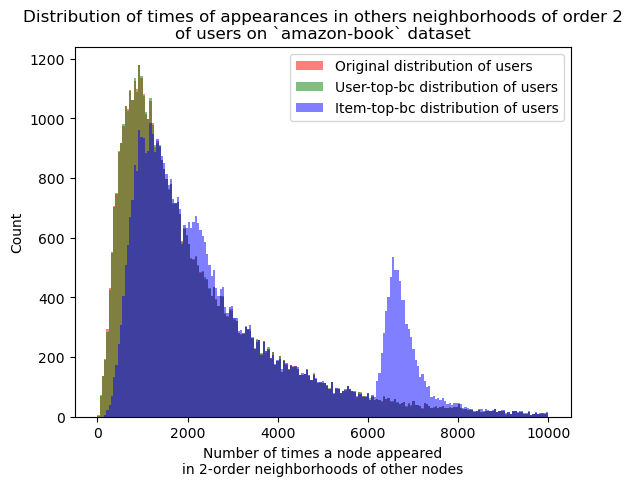

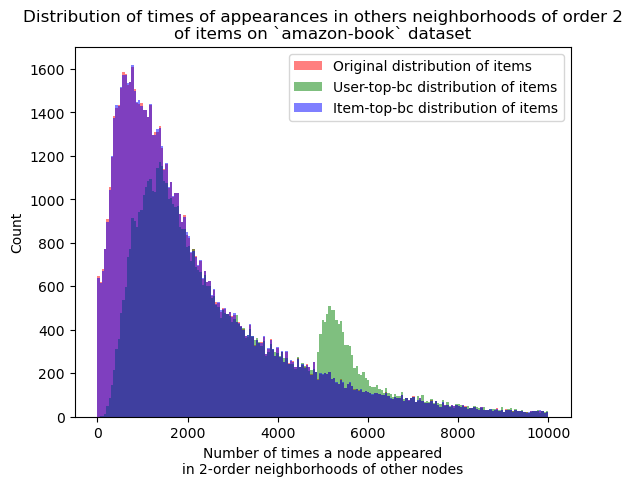

In [18]:
K = 2
for dataset_name in [GOWALLA_DATASET_NAME, YELP_2018_DATASET_NAME, AMAZON_BOOK_DATASET_NAME]:
    G_orig, _, _ = get_repaired_interactions(dataset_name)
    G_user_top_bc, _, _ = get_repaired_interactions(dataset_name + "--c-bc--user--q=0.99")
    G_item_top_bc, _, _ = get_repaired_interactions(dataset_name + "--c-bc--item--q=0.99")

    orig_u_khop_counts, orig_i_khop_counts = get_user_item_khop_neighbors_dicts(G_orig, k=K)
    user_top_bc_u_khop_counts, user_top_bc_i_khop_counts = get_user_item_khop_neighbors_dicts(G_user_top_bc, k=K)
    item_top_bc_u_khop_counts, item_top_bc_i_khop_counts = get_user_item_khop_neighbors_dicts(G_item_top_bc, k=K)

    plot_khop_dict_distribution_h2(orig_u_khop_counts, user_top_bc_u_khop_counts, item_top_bc_u_khop_counts, "user", k=K)
    plot_khop_dict_distribution_h2(orig_i_khop_counts, user_top_bc_i_khop_counts, item_top_bc_i_khop_counts, "item", k=K)

# H3 (Pre-explorationg using Improved Jacard Index)

810127 815914 817109


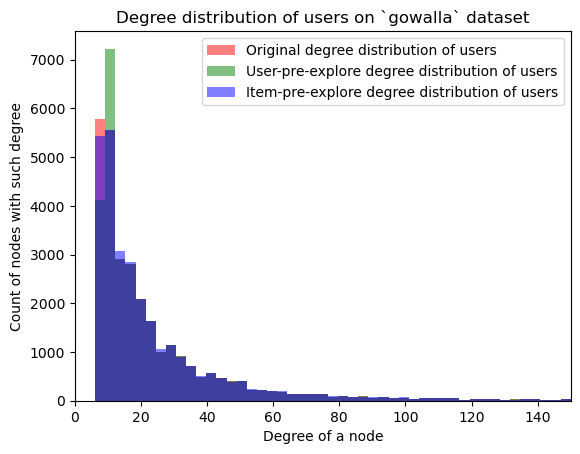

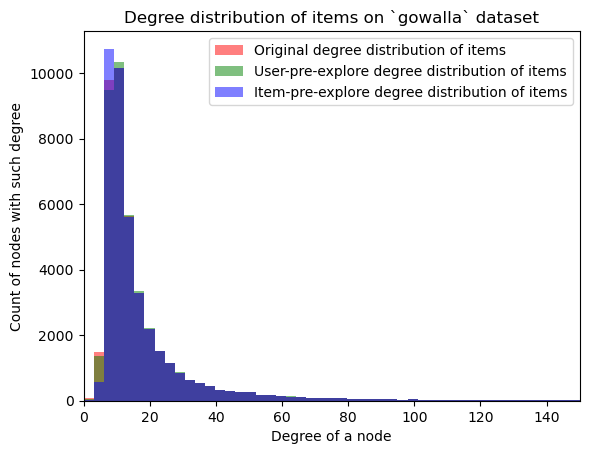

1237258 1242825 1244240


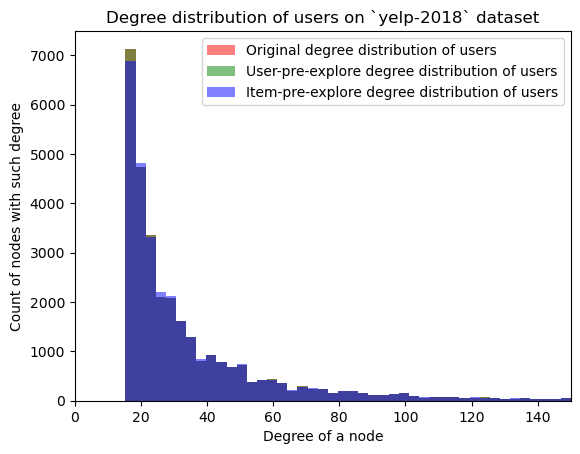

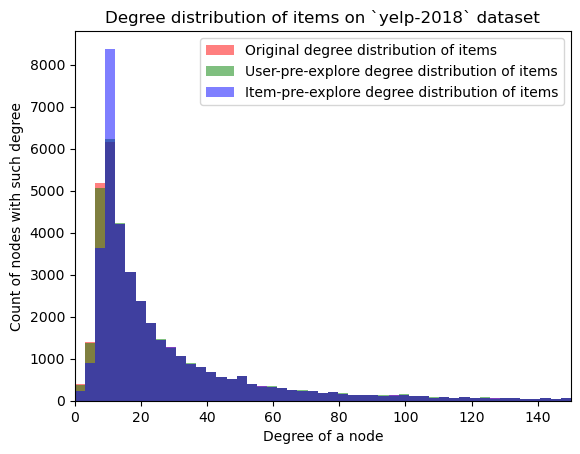

2380729 2389671 2399007


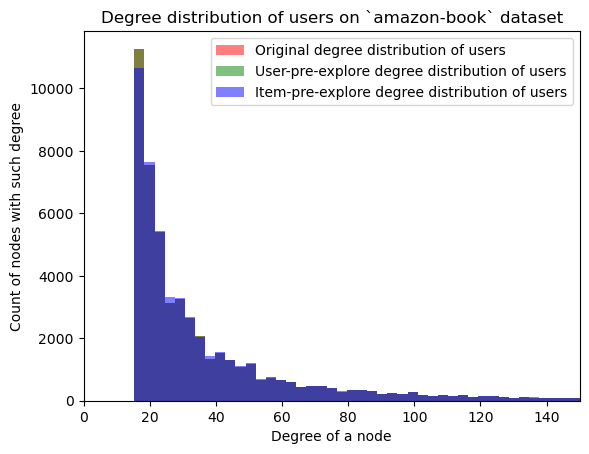

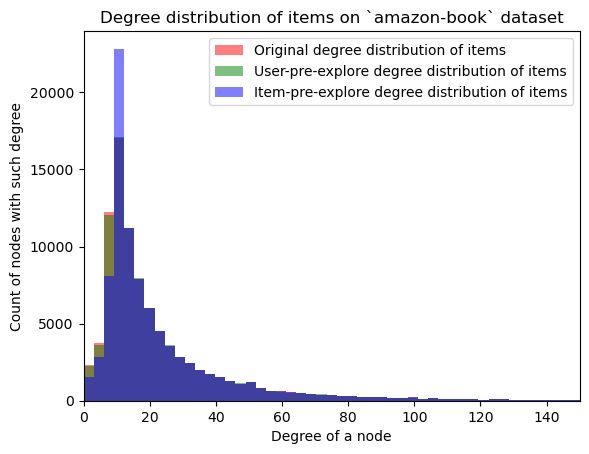

In [34]:
for dataset_name in [GOWALLA_DATASET_NAME, YELP_2018_DATASET_NAME, AMAZON_BOOK_DATASET_NAME]:
    G_orig, _, _ = get_repaired_interactions(dataset_name)
    G_user_exp, _, _ = get_repaired_interactions(dataset_name + "--soft-chns--user--q=0.15")
    G_item_exp, _, _ = get_repaired_interactions(dataset_name + "--soft-chns--item--q=0.15")

    print(len(G_orig.edges), len(G_user_exp.edges), len(G_item_exp.edges))

    orig_u_distr, orig_i_distr = get_user_item_degree_distribution(G_orig)
    user_exp_u_distr, user_exp_i_distr = get_user_item_degree_distribution(G_user_exp)
    item_exp_u_distr, item_exp_i_distr = get_user_item_degree_distribution(G_item_exp)

    plot_degree_distributions(dataset_name, orig_u_distr, user_exp_u_distr, item_exp_u_distr, USER_COLNAME, "pre-explore")
    plot_degree_distributions(dataset_name, orig_i_distr, user_exp_i_distr, item_exp_i_distr, ITEM_COLNAME, "pre-explore")